<a href="https://colab.research.google.com/github/Tonge-Shim/pytorchstudy/blob/main/chap5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import torch

#celcius -> fahrenheit
w = 5.5556, b = -17.7778

In [3]:
t_c = [0.5, 14.0, 15.0, 28.0, 11.0, 8.0, 3.0, -4.0, 6.0, 13.0, 21.0]
t_u = [35.7, 55.9, 58.2, 81.9, 56.3, 48.9, 33.9, 21.8, 48.4, 60.4, 68.4]
t_c = torch.tensor(t_c)
t_u = torch.tensor(t_u)

parameters will be pytorch scalars(zero-dimensional tensors)

In [4]:
def model(t_u, w, b):
    return w * t_u +b
#mean square loss
def loss_fn(t_p, t_c):
    squared_diffs = (t_p - t_c)**2
    return squared_diffs.mean()
#initialize parameters
w = torch.ones(())
b = torch.zeros(())

t_p = model(t_u, w, b)
print(t_p)
loss = loss_fn(t_p, t_c)
print(loss)


tensor([35.7000, 55.9000, 58.2000, 81.9000, 56.3000, 48.9000, 33.9000, 21.8000,
        48.4000, 60.4000, 68.4000])
tensor(1763.8848)


In [5]:
#delta에 따른 차이는?
delta = 0.1
loss_rate_of_change_w = (loss_fn(model(t_u, w+delta, b), t_c) - loss_fn(model(t_u, w-delta, b), t_c)) / (2.0*delta)
loss_rate_of_change_b = (loss_fn(model(t_u, w, b+delta), t_c) - loss_fn(model(t_u, w, b-delta), t_c)) / (2.0*delta)

In [6]:
learning_rate = 1e-2
w = w - learning_rate * loss_rate_of_change_w
b = b - learning_rate * loss_rate_of_change_b

#*the gradient*
compute the individual derivatives of the loss with respect to each parameter and put them in a vector of defivatives: the gradient.

In [7]:
def dloss_fn(t_p, t_c):
    dsq_diffs = 2*(t_p-t_c) / t_p.size(0)
    return dsq_diffs
def dmodel_dw(t_u, w, b):
    return t_u
def dmodel_db(t_u, w, b):
    return 1.0
def grad_fn(t_u, t_c, t_p, w, b):
    dloss_dtp = dloss_fn(t_p, t_c)
    dloss_dw = dloss_dtp * dmodel_dw(t_u, w, b)
    dloss_db = dloss_dtp * dmodel_db(t_u, w, b)
    return torch.stack([dloss_dw.sum(), dloss_db.sum()])#what is this stack function?



In [8]:
def training_loop(n_epochs, learning_rate, params, t_u, t_c):
    for epoch in range(1, n_epochs + 1):
        w,b = params
        t_p = model(t_u, w, b)
        loss = loss_fn(t_p, t_c)
        grad = grad_fn(t_u, t_c, t_p, w, b)

        params = params - learning_rate * grad

        #print("Epoch %d, Loss %f" % (epoch, float(loss)))
    return params



In [9]:
training_loop(n_epochs = 100, learning_rate = 1e-2, params = torch.tensor([1.0, 0.0]), t_u = t_u, t_c = t_c)
#망...

tensor([nan, nan])

In [10]:
training_loop(n_epochs = 100, learning_rate = 1e-4, params = torch.tensor([1.0, 0.0]), t_u = t_u, t_c = t_c)


tensor([ 0.2327, -0.0438])

#changing the inputs so that the gradients aren't quite so different

In [11]:
t_un = 0.1 * t_u#normalized --> t_u + n

In [12]:
training_loop(n_epochs = 100, learning_rate = 1e-2, params = torch.tensor([1.0, 0.0]), t_u = t_un, t_c = t_c)


tensor([ 2.7553, -2.5162])

#epoch up

In [13]:
params = training_loop(n_epochs = 5000, learning_rate = 1e-2, params = torch.tensor([1.0, 0.0]), t_u = t_un, t_c = t_c)
#nice

#visualizing

In [14]:
%matplotlib inline
from matplotlib import pyplot as plt

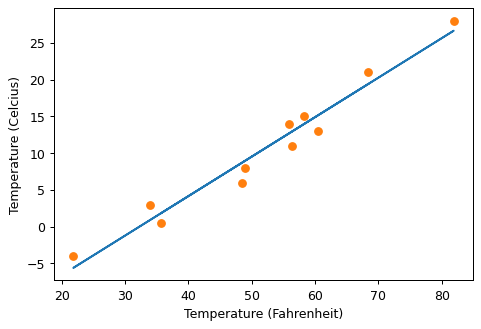

In [15]:
t_p = model(t_un, *params)#unpacking
fig = plt.figure(dpi = 90)#이게 뭐고/size maybe
plt.xlabel("Temperature (Fahrenheit)")
plt.ylabel("Temperature (Celcius)")
plt.plot(t_u.numpy(), t_p.detach().numpy())#result
plt.plot(t_u.numpy(), t_c.numpy(), 'o')#inputs

#Autograd

In [16]:
params = torch.tensor([1.0, 0.0], requires_grad = True)
#requires_grad = True: track the entire family tree of tensors resulting 
#from operations on parmas.

In [17]:
params.grad is None

True

In [18]:
loss = loss_fn(model(t_u, *params), t_c)
loss.backward()

params.grad

tensor([4517.2969,   82.6000])

#backward
calling backward will lead derivatives to *accumulate* at leaf nodes.
so if backward was called earlier, the loss is evaluated again, backward is called again and the gradient at each lear is accumulated on top of the one computed at the previous iteration, which leads to an incorrect value for the gradient.


> in order to prevent this from occuring, we need to zero the gradient explicitly at each iteration--> zero_ method



In [19]:
if params.grad is not None:
    params.grad.zero_()

In [21]:
def training_loop(n_epochs, learning_rate, params, t_u, t_c):
    for epoch in range(1, n_epochs + 1):
        if params.grad is not None:
            params.grad.zero_()

        t_p = model(t_u, *params)
        loss = loss_fn(t_p, t_c)
        loss.backward()

        with torch.no_grad():
            params -= learning_rate * params.grad
        
        if epoch%500 == 0:
            print('Epoch %d, Loss %f' % (epoch, float(loss)))

    return params

In [22]:
training_loop(
    n_epochs = 5000,
    learning_rate = 1e-2,
    params = torch.tensor([1.0, 0.0], requires_grad = True),
    t_u = t_un, 
    t_c = t_c
)

Epoch 500, Loss 7.860115
Epoch 1000, Loss 3.828538
Epoch 1500, Loss 3.092191
Epoch 2000, Loss 2.957698
Epoch 2500, Loss 2.933134
Epoch 3000, Loss 2.928648
Epoch 3500, Loss 2.927830
Epoch 4000, Loss 2.927679
Epoch 4500, Loss 2.927652
Epoch 5000, Loss 2.927647


tensor([  5.3671, -17.3012], requires_grad=True)

In [23]:
import torch.optim as optim
dir(optim)

['ASGD',
 'Adadelta',
 'Adagrad',
 'Adam',
 'AdamW',
 'Adamax',
 'LBFGS',
 'Optimizer',
 'RMSprop',
 'Rprop',
 'SGD',
 'SparseAdam',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 '_functional',
 '_multi_tensor',
 'lr_scheduler',
 'swa_utils']

#SGD
stochastic gradient descent


In [24]:
params = torch.tensor([1.0, 0.0], requires_grad=True)
learning_rate = 1e-5
optimizer = optim.SGD([params], lr = learning_rate)

In [25]:
t_p = model(t_u, *params)
loss = loss_fn(t_p, t_c)
loss.backward()
optimizer.step()
params

tensor([ 9.5483e-01, -8.2600e-04], requires_grad=True)

In [32]:
params = torch.tensor([1.0, 0.0], requires_grad=True)
learning_rate = 1e-2
optimizer = optim.SGD([params], lr = learning_rate)

t_p = model(t_un, *params)
loss = loss_fn(t_p, t_c)

optimizer.zero_grad()
loss.backward()
optimizer.step()

params

tensor([1.7761, 0.1064], requires_grad=True)

In [35]:
def training_loop(n_epochs, optimizer, params, t_u, t_c):
    for epoch in range(1, n_epochs + 1):
        t_p = model(t_u, *params)
        loss = loss_fn(t_p, t_c)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if epoch%500 == 0:
            print('Epoch %d, Loss %f' % (epoch, float(loss)))

    return params

params = torch.tensor([1.0, 0.0], requires_grad=True)
learning_rate = 1e-2
optimizer = optim.SGD([params], lr = learning_rate)

training_loop(
    n_epochs = 5000,
    optimizer = optimizer,
    params = params,
    t_u = t_un, 
    t_c = t_c)

Epoch 500, Loss 7.860120
Epoch 1000, Loss 3.828538
Epoch 1500, Loss 3.092191
Epoch 2000, Loss 2.957698
Epoch 2500, Loss 2.933134
Epoch 3000, Loss 2.928648
Epoch 3500, Loss 2.927830
Epoch 4000, Loss 2.927679
Epoch 4500, Loss 2.927652
Epoch 5000, Loss 2.927647


tensor([  5.3671, -17.3012], requires_grad=True)

#Adam
sophisticated optimizer in which the learning rate is set adaptively. +, less sensitive to the scaling of the parameters--so insensitive that we can go back to using the original input t_u, and even increase the learning rate to 1e-1, and Adam won't even blink.

In [36]:
params = torch.tensor([1.0, 0.0], requires_grad=True)
learning_rate = 1e-1
optimizer = optim.Adam([params], lr = learning_rate)

training_loop(
    n_epochs = 2000,
    optimizer = optimizer,
    params = params,
    t_u = t_u, 
    t_c = t_c)

Epoch 500, Loss 7.612900
Epoch 1000, Loss 3.086700
Epoch 1500, Loss 2.928579
Epoch 2000, Loss 2.927644


tensor([  0.5367, -17.3021], requires_grad=True)

#cure for overfitting


> 1. make sure we get enough data for the process
> 2. make sure the model that is capable of fitting the training data is as regular as possible in between them
>> add penalization terms to the loss function to make it cheaper for the model to behave more smoothly and change more slowly.
>> add noise to the input samples and train them too



#Shuffling a Dataset
randperm function

In [37]:
n_samples = t_u.shape[0]
n_val = int(0.2 * n_samples)#11*0.2 = 2.2
shuffled_indices = torch.randperm(n_samples)

train_indices = shuffled_indices[:-n_val]# ~ -2끝에서 두번째 까지
val_indices = shuffled_indices[-n_val:]# -2부터 끝까지

train_indices, val_indices

(tensor([5, 7, 1, 4, 3, 8, 2, 0, 6]), tensor([10,  9]))

In [40]:
train_t_u = t_u[train_indices]
train_t_c = t_c[train_indices]

val_t_u = t_u[val_indices]
val_t_c = t_c[val_indices]

train_t_un = 0.1 * train_t_u
val_t_un = 0.1 * val_t_u

In [42]:
def training_loop(n_epochs, optimizer, params, train_t_u, val_t_u, train_t_c, val_t_c):
    for epoch in range(1, n_epochs + 1):
        train_t_p = model(train_t_u, *params)
        train_loss = loss_fn(train_t_p, train_t_c)

        val_t_p = model(val_t_u, *params)
        val_loss = loss_fn(train_t_p, train_t_c)

        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()
        
        if epoch <= 3 or epoch%500 == 0:
            print(f"Epoch {epoch}, Training loss{train_loss.item():.4f},"
                  f"Validation loss {val_loss.item(): .4f}")

    return params

params = torch.tensor([1.0, 0.0], requires_grad=True)
learning_rate = 1e-2
optimizer = optim.SGD([params], lr = learning_rate)

training_loop(
    n_epochs = 3000,
    optimizer = optimizer,
    params = params,
    train_t_u = train_t_un, 
    val_t_u = val_t_un,
    train_t_c = train_t_c,
    val_t_c = val_t_c)

Epoch 1, Training loss70.5623,Validation loss  70.5623
Epoch 2, Training loss40.3757,Validation loss  40.3757
Epoch 3, Training loss34.2207,Validation loss  34.2207
Epoch 500, Training loss7.1204,Validation loss  7.1204
Epoch 1000, Training loss3.4128,Validation loss  3.4128
Epoch 1500, Training loss2.8828,Validation loss  2.8828
Epoch 2000, Training loss2.8070,Validation loss  2.8070
Epoch 2500, Training loss2.7962,Validation loss  2.7962
Epoch 3000, Training loss2.7946,Validation loss  2.7946


tensor([  5.3306, -17.0593], requires_grad=True)